# Representational Similarity Analysis assignment
## Portfolio assignment 4

### Activate virtual environment

In [1]:
import os
path = '/work/SofieNørboMosegaard#5741/AdvCogNeuro/'
os.chdir(path)
!./activate.sh

Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


### Import packages

In [32]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from scipy.stats import kendalltau

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


### Load the data

In [14]:
from utils import load_data_for_a_subj, digitize_rdm, ns_data_dir

In [4]:
# Load the data for one subject
subj_initials = 'KO'
ns_data_dir = os.path.join('/work/notebooks_fMRI/data', 'NinetySix')

all_subj_initials = {'BE', 'KO', 'SN', 'TI'}
rois_to_keep = ['lFFA', 'rFFA', 'lPPA', 'rPPA']

def load_data_for_a_subj(subj_initials):
    assert subj_initials in all_subj_initials
    images = scipy.io.loadmat(
        os.path.join(ns_data_dir, '%s_images.mat' % (subj_initials))
    )['images']  
    data = scipy.io.loadmat(
        os.path.join(ns_data_dir, '%s_roi_data.mat' % (subj_initials))
    )
    
    # Unpack metadata 
    roi_data_all = data['roi_data']
    roi_names = data['roinames']
    labels = np.array(data['labels'])
    categoryNames = data['categoryNames']

    # Re-format metadata labels and ROIs
    n_categories = categoryNames.shape[1]
    n_rois = roi_names.shape[1]
    categories = [categoryNames[0, i][0] for i in range(n_categories)]
    roi_names = [roi_names[0, i][0] for i in range(n_rois)]
    labels = np.squeeze(labels) 
    label_dict = {categories[i]: i+1 for i in range(len(categories))}

    # Remove r/lLO
    roi_data = []
    for r in range(n_rois): 
        if roi_names[r] in rois_to_keep: 
            roi_data.append(roi_data_all[0, r])
    roi_names = rois_to_keep
    n_rois = len(rois_to_keep)
    return images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict


data_pack = load_data_for_a_subj(subj_initials)
images, roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict = data_pack
n_stimuli = len(images)

### Inspect the data

In [5]:
print('ROI names:',roi_names)
print('Stimulus categories:', categories)
print(type(labels))
print('Trial labels:', labels)
print('Region of interest matrix sizes:')
for roi in roi_data:
    print (roi.shape)

ROI names: ['lFFA', 'rFFA', 'lPPA', 'rPPA']
Stimulus categories: ['artificial inanimate', 'human bodypart', 'human face', 'natural inanimate', 'nonhuman bodypart', 'nonhuman face']
<class 'numpy.ndarray'>
Trial labels: [2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 6
 6 6 6 6 6 6 6 6 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Region of interest matrix sizes:
(96, 293)
(96, 315)
(96, 63)
(96, 9)


### Visualize the data

##### Plotting stimulus categories

Text(0, 0.5, 'Stimulus category')

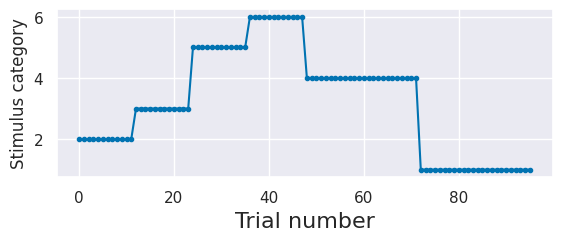

In [6]:
plt.figure()

# Label plot
plt.subplot(2,1,2)
plt.plot(labels,'.-')
plt.xlabel('Trial number', fontsize=16)
plt.ylabel('Stimulus category', fontsize=12)

#### Plotting the lFFA data

In [7]:
print('ROI names: ', roi_names)

ROI names:  ['lFFA', 'rFFA', 'lPPA', 'rPPA']


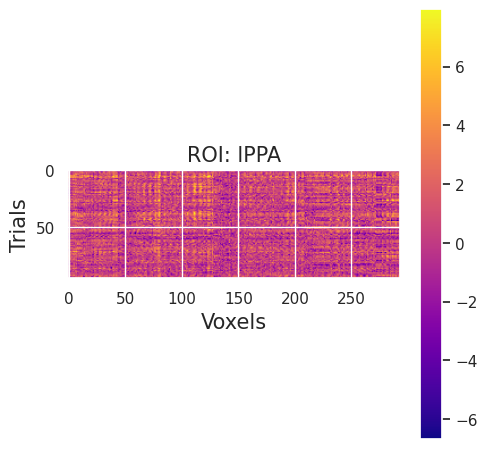

In [9]:
# Choose your ROI here (lPPA = 0)!
roi_id = 0

# Create a data matrix R
R=roi_data[roi_id]

#Plot it
fig, axis = plt.subplots(1,1, figsize = (5, 5))
fig.tight_layout()
plt.imshow(R, cmap = 'plasma')
axis.set_title("ROI: lPPA", fontsize = 15)
axis.set_xlabel("Voxels", fontsize = 15)
axis.set_ylabel("Trials", fontsize = 15)
plt.colorbar()

### Create a similarity matrix

Text(0, 0.5, 'trial number')

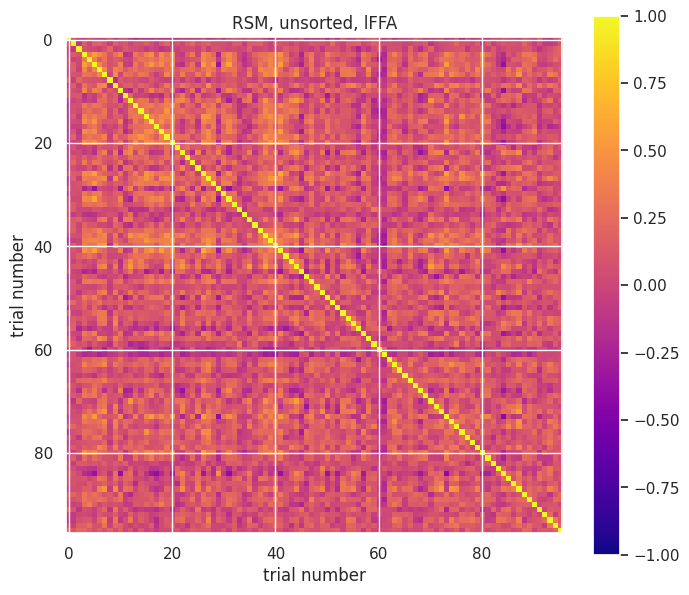

In [10]:
roi_id = 0

# Plot figure of these correlations
f, ax = plt.subplots(1,1, figsize = (8, 7))

plt.imshow(np.corrcoef(roi_data[roi_id]), cmap = 'plasma', vmin = -1,vmax = 1,)
plt.colorbar()
ax.set_title('RSM, unsorted, %s' % (roi_names[roi_id])) 
ax.set_xlabel('trial number')
ax.set_ylabel('trial number')

### Reorder data into categories

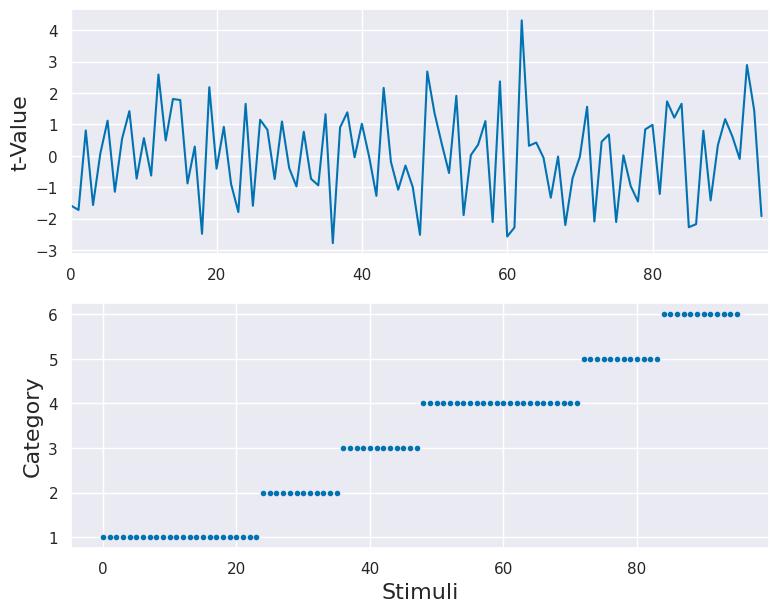

In [11]:
# Add the stimulus condition labels so that we can sort the data --> collecting rows from the same condition together
sort_ids = labels.argsort()
lPPA_sorted = roi_data[1][sort_ids, :]

plt.figure(figsize = (9,7))

plt.subplot(2,1,1)
plt.plot(lPPA_sorted[:,0])
plt.ylabel('t-Value', fontsize = 16)
plt.xlim(0, 96)

plt.subplot(2,1,2)
plt.plot(labels[sort_ids],'.')
plt.xlabel('Stimuli', fontsize = 16)
plt.ylabel('Category', fontsize = 16)
plt.show()

Text(0.5, 1.0, 'RSM, sorted, lFFA')

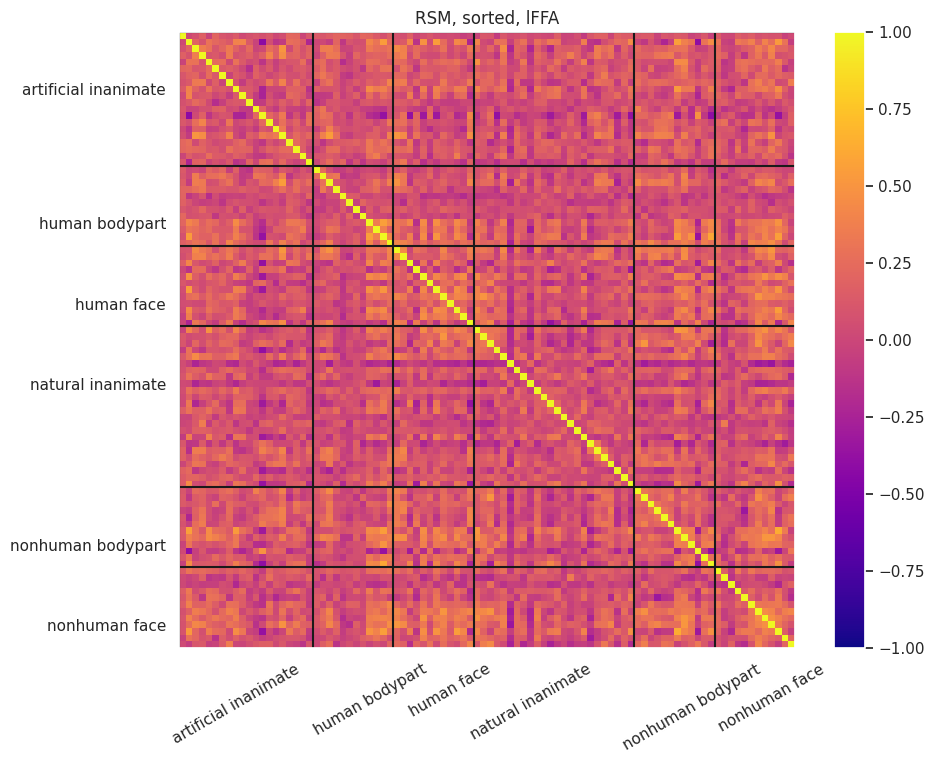

In [12]:
roi_id = 0

# Calculate the RSM
rsm = np.corrcoef(roi_data[roi_id][sort_ids, :][:92,]) # only include the first 92 trials, the last 4 are NaNs.

# Plot 
f, ax = plt.subplots(1, 1, figsize = (10, 8))
plt.imshow(rsm, cmap = 'plasma', vmin = -1,vmax = 1,)
plt.colorbar()
plt.grid(False)

# Pull out the bin edges between the different categories
binsize = np.histogram(labels[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(categories, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(categories)
ax.vlines(edges-0.5, 0-0.5, 91.5, colors = "k")
ax.hlines(edges-0.5, 0-0.5, 91.5, colors = "k")

ax.set_title('RSM, sorted, %s' % roi_names[roi_id])

Text(0.5, 1.0, 'RSM digitized lFFA')

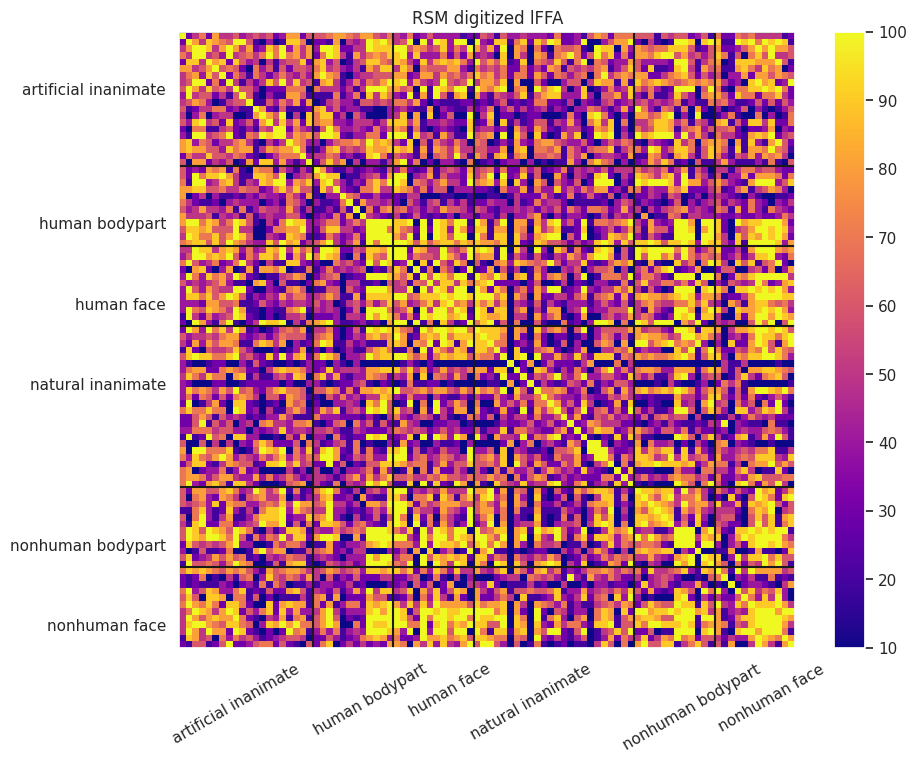

In [15]:
# Plot the RSM
f, ax = plt.subplots(1,1, figsize = (10, 8))
plt.imshow(digitize_rdm(rsm), cmap = 'plasma', )
plt.colorbar()
plt.grid(False)

# Pull out the bin edges between the different categories
binsize = np.histogram(labels[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(categories, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(categories)
ax.vlines(edges-0.5, 0-0.5, 91.5, colors = "k")
ax.hlines(edges-0.5, 0-0.5, 91.5, colors = "k")

ax.set_title('RSM digitized %s' % roi_names[roi_id])

### Reorder data

In [16]:
print(categories)

['artificial inanimate', 'human bodypart', 'human face', 'natural inanimate', 'nonhuman bodypart', 'nonhuman face']


In [20]:
# Add the stimulus condition labels
new_order = ('human face', 'human bodypart', 'nonhuman face', 'nonhuman bodypart', 'natural inanimate', 'artificial inanimate')

# Make a loop to make a vector of new labels
category_vec = []
labels2 = []

for nn in range(len(labels[:92,])):

    # Make a vector with category names, rather than numeric labels
    category_vec.append(categories[int(labels[nn]-1)])
    
    # Compare current category to new order, to make a vector of labels according the the new order
    for nnn in range(len(new_order)):
        if category_vec[nn]==new_order[nnn]:
            labels2.append(nnn)

print(category_vec)
print(len(labels2))

labels2=np.array(labels2)
sort_ids2 = labels2.argsort()

['human bodypart', 'human bodypart', 'human bodypart', 'human bodypart', 'human bodypart', 'human bodypart', 'human bodypart', 'human bodypart', 'human bodypart', 'human bodypart', 'human bodypart', 'human bodypart', 'human face', 'human face', 'human face', 'human face', 'human face', 'human face', 'human face', 'human face', 'human face', 'human face', 'human face', 'human face', 'nonhuman bodypart', 'nonhuman bodypart', 'nonhuman bodypart', 'nonhuman bodypart', 'nonhuman bodypart', 'nonhuman bodypart', 'nonhuman bodypart', 'nonhuman bodypart', 'nonhuman bodypart', 'nonhuman bodypart', 'nonhuman bodypart', 'nonhuman bodypart', 'nonhuman face', 'nonhuman face', 'nonhuman face', 'nonhuman face', 'nonhuman face', 'nonhuman face', 'nonhuman face', 'nonhuman face', 'nonhuman face', 'nonhuman face', 'nonhuman face', 'nonhuman face', 'natural inanimate', 'natural inanimate', 'natural inanimate', 'natural inanimate', 'natural inanimate', 'natural inanimate', 'natural inanimate', 'natural ina

Plot the reordered categories using the same code as above.

Text(0.5, 1.0, 'RSM digitized lFFA')

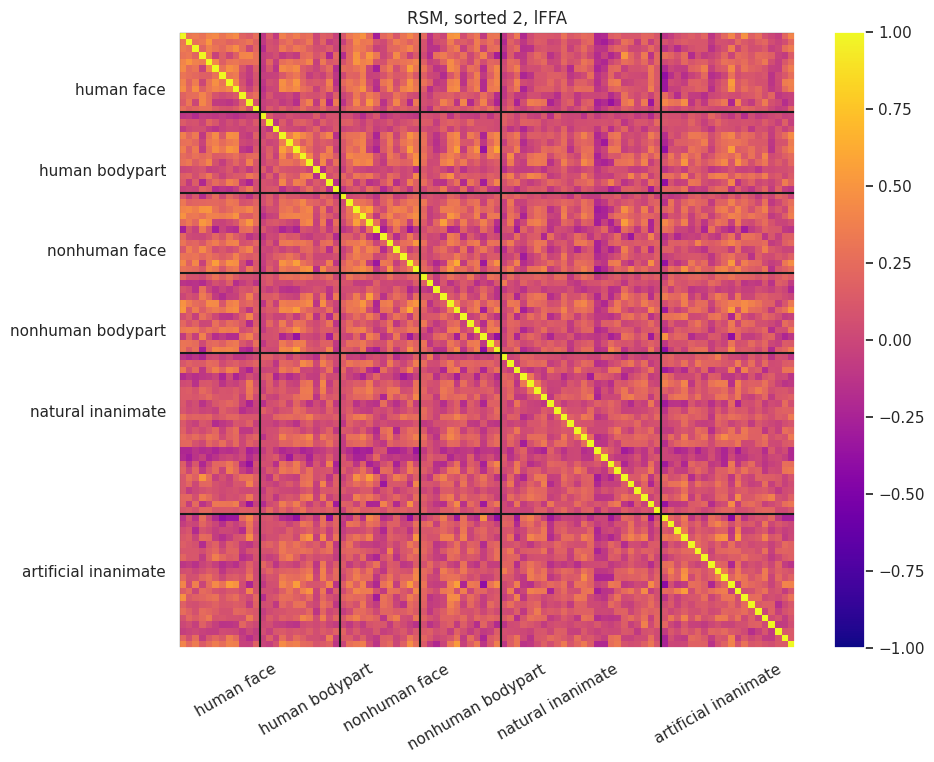

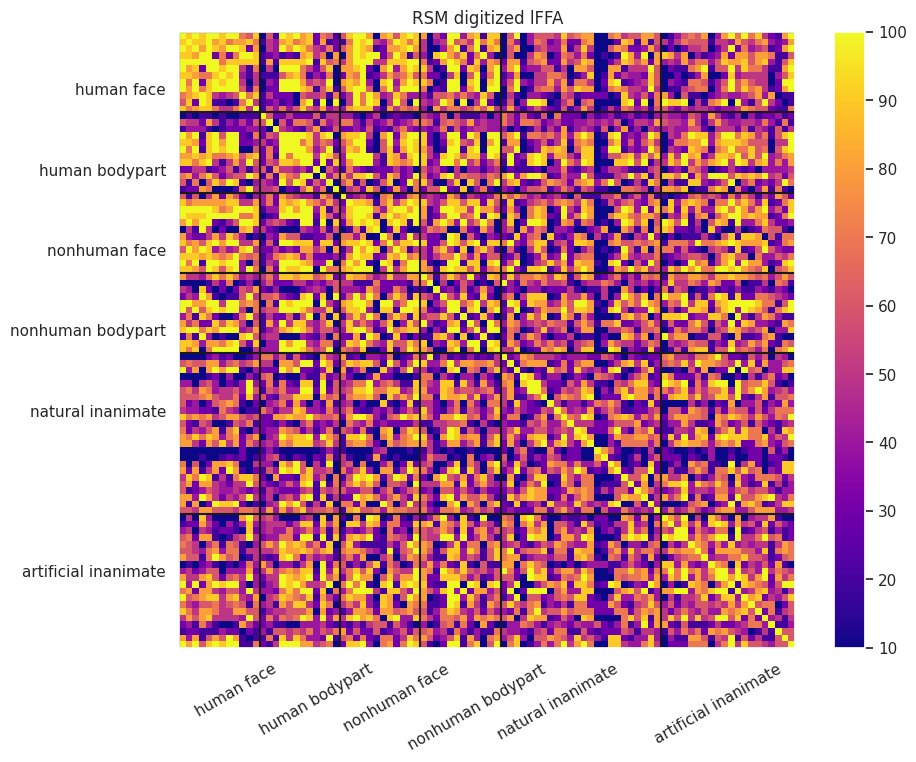

In [21]:
roi_id = 0

# Calculate the RSM
R=roi_data[roi_id][sort_ids2, :][:92,]
rsm2 = np.corrcoef(R)

# Plot 
f, ax = plt.subplots(1,1, figsize = (10, 8))
plt.imshow(rsm2, cmap = 'plasma', vmin = -1,vmax = 1,)
plt.colorbar()
plt.grid(False)

binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges-0.5, 0-0.5, 91.5, colors = "k")
ax.hlines(edges-0.5, 0-0.5, 91.5, colors = "k")

ax.set_title('RSM, sorted 2, %s' % roi_names[roi_id])

# Plot the digitized RSM
f, ax = plt.subplots(1,1, figsize = (10, 8))
plt.imshow(digitize_rdm(rsm2), cmap = 'plasma', )
plt.colorbar()
plt.grid(False)

binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges-0.5, 0-0.5, 91.5, colors = "k")
ax.hlines(edges-0.5, 0-0.5, 91.5, colors = "k")

ax.set_title('RSM digitized %s' % roi_names[roi_id])

### Representational dissimilarity

Text(0.5, 1.0, 'RDM, sorted 2, lFFA')

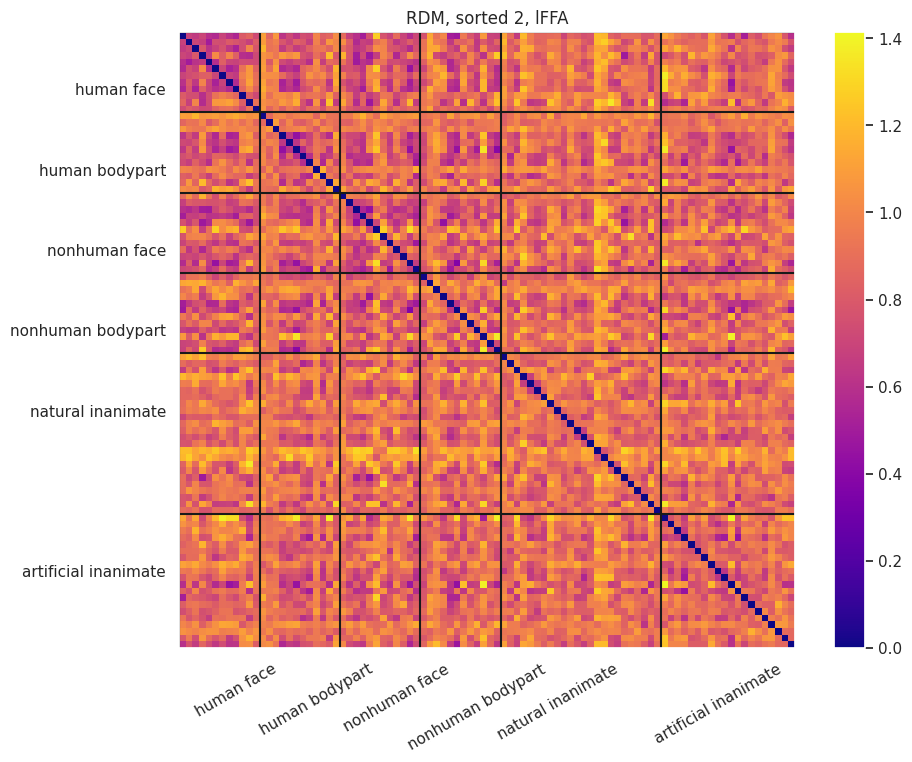

In [22]:
roi_id = 0

R=roi_data[roi_id][sort_ids2, :][:92,]
rdm = 1-np.corrcoef(R) # only include the first 92 trials, the last 4 are NaNs.

# Plot 
f, ax = plt.subplots(1,1, figsize = (10, 8))
plt.imshow(rdm, cmap = 'plasma',)
plt.colorbar()
plt.grid(False)

binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges-0.5, 0-0.5, 91.5, colors = "k")
ax.hlines(edges-0.5, 0-0.5, 91.5, colors = "k")

ax.set_title('RDM, sorted 2, %s' % roi_names[roi_id])

Text(0.5, 1.0, 'RDM (cosine distance), sorted, lFFA')

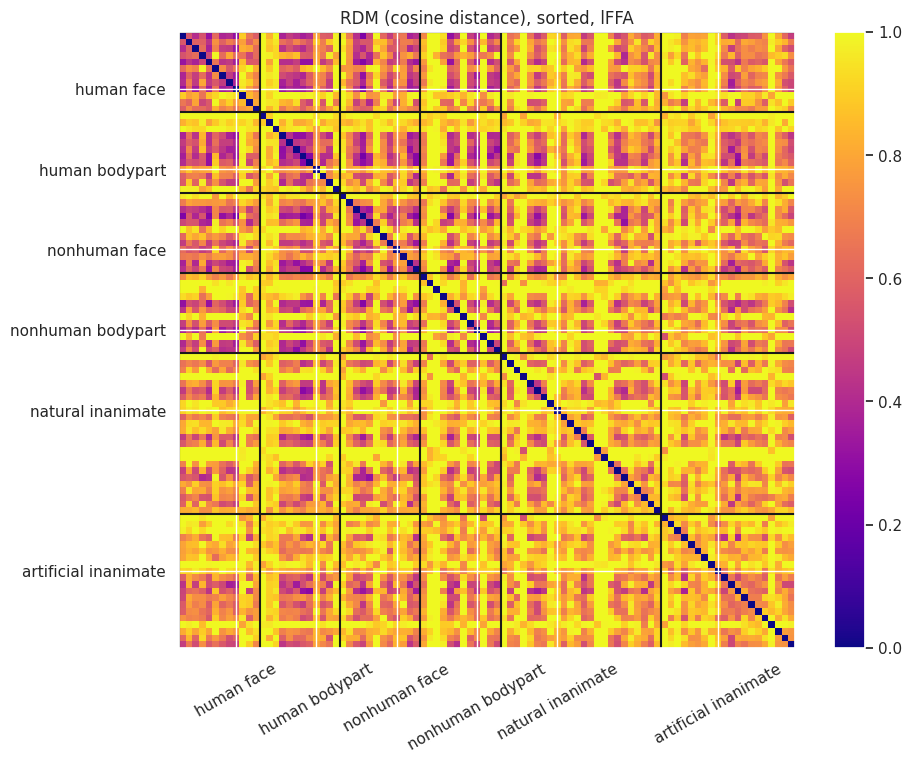

In [23]:
# Calculate the RDM using the metric cosine
rdm_cos = pairwise_distances(R, metric = 'cosine')

f, ax = plt.subplots(1,1, figsize = (10, 8))
plt.imshow(rdm_cos, cmap = 'plasma', vmin = 0, vmax = 1,)
plt.colorbar()

binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
ax.set_xticks(list(np.array(edges)+8))
ax.set_xticklabels(new_order, rotation = 30)
ax.set_yticks(list(np.array(edges)+8))
ax.set_yticklabels(new_order)
ax.vlines(edges-0.5, 0-0.5, 91.5, colors = "k")
ax.hlines(edges-0.5, 0-0.5, 91.5, colors = "k")

ax.set_title('RDM (cosine distance), sorted, %s' % roi_names[roi_id])

### Model the RDM data

In [24]:
labels_an = 1*(labels2 <= 3)
labels_hum = 1*(labels2 <= 1)
labels_hum_face = 1*(labels2 == 0)

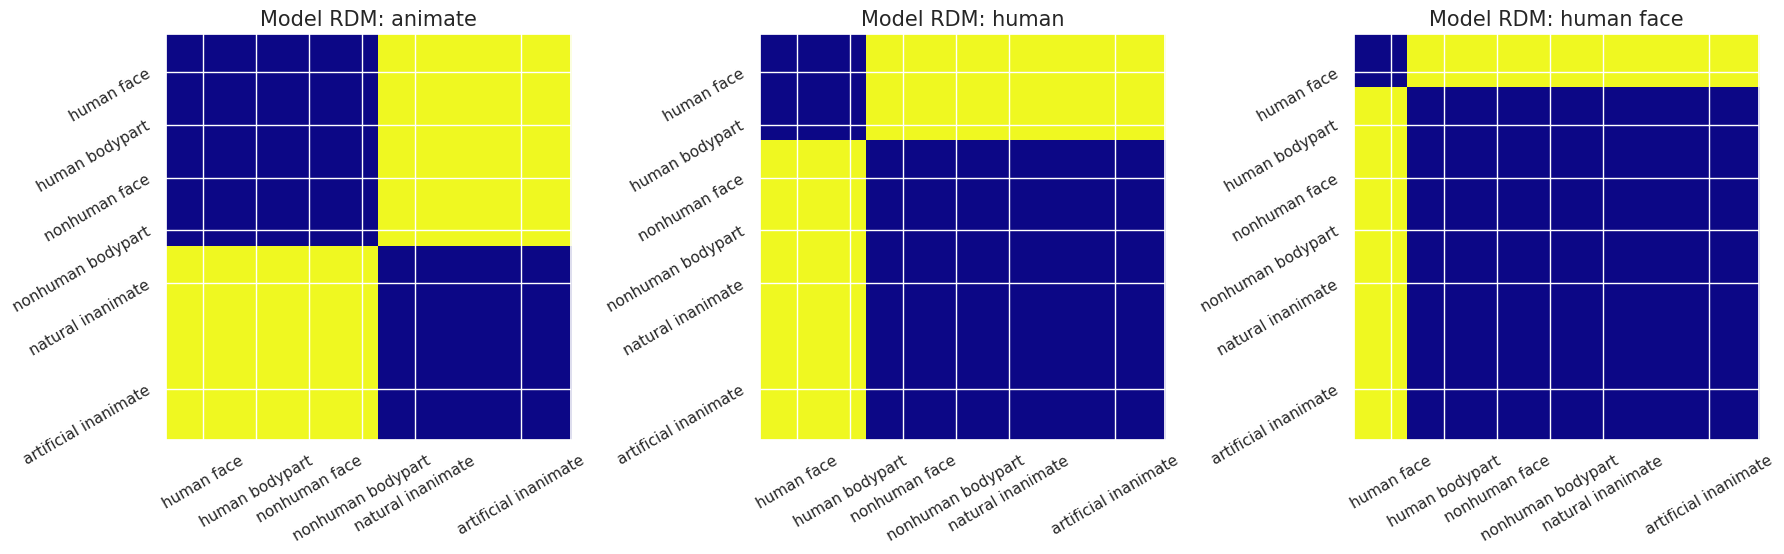

In [26]:
rdm_an = pairwise_distances(labels_an[sort_ids2, np.newaxis], metric = 'matching')
rdm_hum = pairwise_distances(labels_hum[sort_ids2, np.newaxis], metric = 'manhattan')
rdm_hum_face = pairwise_distances(labels_hum_face[sort_ids2, np.newaxis], metric = 'manhattan')

fig, axes = plt.subplots(ncols = 3, figsize =(18, 6))
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]
axes[0].imshow(rdm_an, cmap = 'plasma')
axes[0].set_title("Model RDM: animate", fontsize = 15)

axes[1].imshow(rdm_hum, cmap = 'plasma')
axes[1].set_title("Model RDM: human", fontsize = 15)

axes[2].imshow(rdm_hum_face, cmap = 'plasma')
axes[2].set_title("Model RDM: human face", fontsize = 15)

for i in range(3):
    axes[i].set_xticks(list(np.array(edges) + 8))
    axes[i].set_xticklabels(new_order, rotation = 30)
    axes[i].set_yticks(list(np.array(edges) + 8))
    axes[i].set_yticklabels(new_order,rotation = 30)
fig.tight_layout()
fig.show()

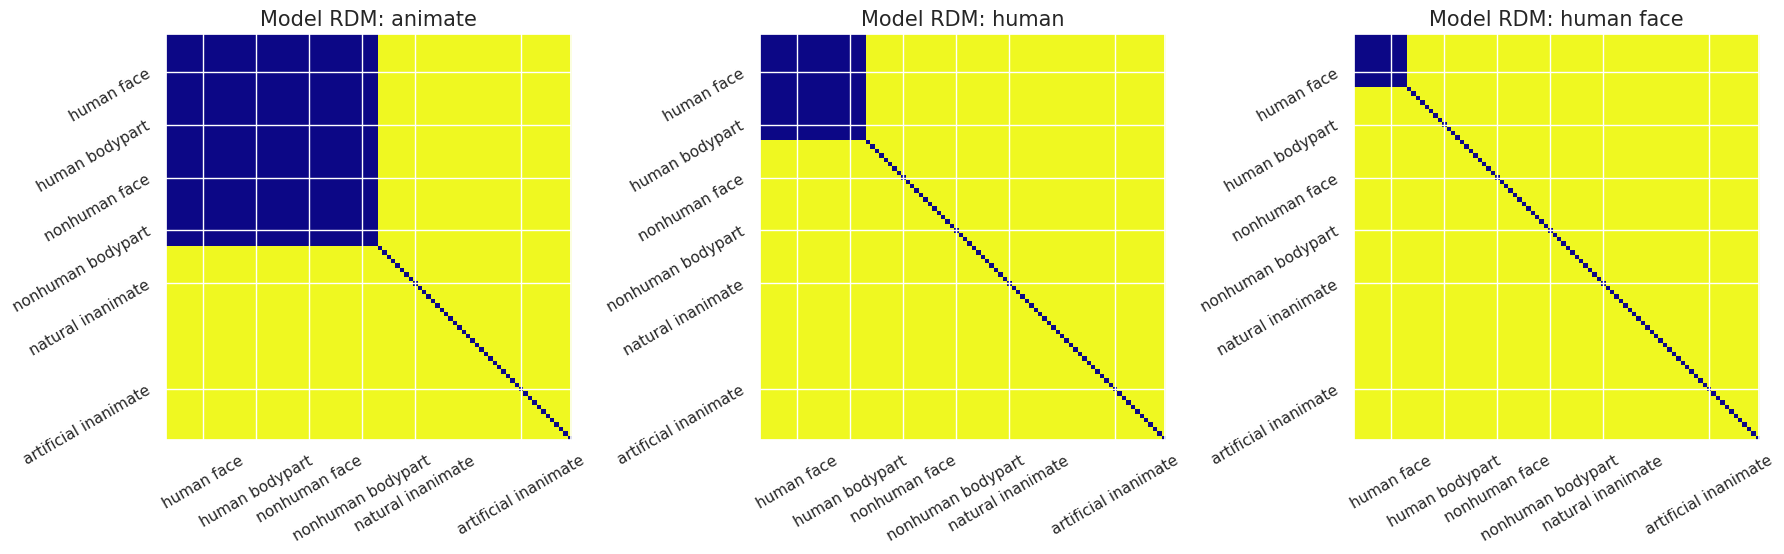

In [27]:
x1 = np.tile(labels_an[sort_ids2], (sum(labels_an), 1))
x2 = np.zeros((len(labels_an) - sum(labels_an), len(labels_an)), dtype = int)
rdm_an2 = abs(1-np.concatenate((x1, x2), axis = 0))
np.fill_diagonal(rdm_an2, 0)

x1 = np.tile(labels_hum[sort_ids2], (sum(labels_hum), 1))
x2 = np.zeros((len(labels_hum) - sum(labels_hum), len(labels_hum)), dtype = int)
rdm_hum2 = abs(1 - np.concatenate((x1, x2), axis = 0))
np.fill_diagonal(rdm_hum2, 0)

x1 = np.tile(labels_hum_face[sort_ids2], (sum(labels_hum_face), 1))
x2 = np.zeros((len(labels_hum_face) - sum(labels_hum_face), len(labels_hum_face)), dtype = int)
rdm_hum_face2 = abs(1 - np.concatenate((x1, x2), axis = 0))
np.fill_diagonal(rdm_hum_face2, 0)

fig, axes = plt.subplots(ncols = 3, figsize = (18, 6))
binsize = np.histogram(labels2[:92,], 6)[0]
edges = np.concatenate([np.asarray([0]), np.cumsum(binsize)])[:-1]

axes[0].imshow(rdm_an2 ,cmap = 'plasma')
axes[0].set_title("Model RDM: animate", fontsize = 15)

axes[1].imshow(rdm_hum2, cmap = 'plasma')
axes[1].set_title("Model RDM: human", fontsize = 15)

axes[2].imshow(rdm_hum_face2, cmap = 'plasma')
axes[2].set_title("Model RDM: human face", fontsize = 15)

for i in range(3):
    axes[i].set_xticks(list(np.array(edges) + 8))
    axes[i].set_xticklabels(new_order, rotation = 30)
    axes[i].set_yticks(list(np.array(edges) + 8))
    axes[i].set_yticklabels(new_order,rotation = 30)
fig.tight_layout()
fig.show()

### Testing RDMs

In [29]:
rdv_cos = squareform(rdm_cos.round(5))
print("Shape rdv_cos:", rdv_cos.shape)

Shape rdv_cos: (4186,)


In [30]:
rdv_an = squareform(rdm_an2)
print("Shape rdv_an:", rdv_an.shape)

rdv_hum = squareform(rdm_hum2)
print("Shape rdv_hum:", rdv_an.shape)

rdv_hum_face = squareform(rdm_hum_face2)
print("Shape rdv_hum_face:", rdv_hum_face.shape)

Shape rdv_an: (4186,)
Shape rdv_hum: (4186,)
Shape rdv_hum_face: (4186,)


In [33]:
rdm_an_corr, pval = kendalltau(rdv_an, rdv_cos)
print("Correlation between animate RDM and RDM(lFFA cosine) (p-value): %.3f (%.3f)" % (rdm_an_corr, pval))

rdm_hum_corr, pval = kendalltau(rdv_hum, rdv_cos)
print("Correlation between human RDM and RDM(lFFA cosine) (p-value): %.3f (%.3f)" % (rdm_hum_corr, pval))

rdm_hum_face_corr, pval = kendalltau(rdv_hum_face, rdv_cos)
print("Correlation between human face RDM and RDM(lFFA cosine) (p-value): %.3f (%.3f)" % (rdm_hum_face_corr, pval))

Correlation between animate RDM and RDM(lFFA cosine) (p-value): 0.114 (0.000)
Correlation between human RDM and RDM(lFFA cosine) (p-value): 0.076 (0.000)
Correlation between human face RDM and RDM(lFFA cosine) (p-value): 0.084 (0.000)
